In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import optim
import torchvision
import matplotlib.pyplot as plt
from time import time
import os
from torchvision import datasets, transforms

In [2]:
batch_size = 64

In [3]:
# Importing train data
train_labels = pd.read_csv("/nfs/stak/users/anandy/research/dataset/MNIST/train labels.csv", delimiter = ",")
train_data_up = pd.read_csv("/nfs/stak/users/anandy/research/dataset/MNIST/train_data_up.csv", delimiter = ",")
train_data_down = pd.read_csv("/nfs/stak/users/anandy/research/dataset/MNIST/train_data_down.csv", delimiter = ",")
train_labels = np.asarray(train_labels)
train_lab = train_labels[:, 0]
train_private_labels = train_labels[:, 1]
train_public_labels = train_labels[:, 2]
train_images_down = np.asarray(train_data_down.iloc[:,:])
train_images_up = np.asarray(train_data_up.iloc[:,:])

# Importing test data
test_labels = pd.read_csv("/nfs/stak/users/anandy/research/dataset/MNIST/test labels.csv", delimiter = ",")
test_data_down = pd.read_csv("/nfs/stak/users/anandy/research/dataset/MNIST/test_data_down.csv", delimiter = ",")
test_data_up = pd.read_csv("/nfs/stak/users/anandy/research/dataset/MNIST/test_data_up.csv", delimiter = ",")
test_labels = np.asarray(test_labels)
test_lab = test_labels[:, 0]
test_private_labels = test_labels[:, 1]
test_public_labels = test_labels[:, 2]
test_images_down = np.asarray(test_data_down.iloc[:,:])
test_images_up = np.asarray(test_data_up.iloc[:,:])

# Importing full sized train and test images and labels
full_train_data = pd.read_csv('/nfs/stak/users/anandy/research/dataset/MNIST/train_data.csv', delimiter=",")
full_test_data = pd.read_csv('/nfs/stak/users/anandy/research/dataset/MNIST/test_data.csv', delimiter=",")
tr_img = np.asarray(full_train_data)
te_img = np.asarray(full_test_data)
train_images = tr_img[:, 3:]
test_images = te_img[:, 3:]

transform = transforms.Compose([transforms.ToTensor()])

In [4]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels=None, private_labels=None, public_labels=None, transforms=None):
        self.images = images
        self.labels = labels
        self.private_labels = private_labels
        self.public_labels = public_labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.images))
    
    def __getitem__(self, idx):
        images = self.images[idx, :]
        images = np.asarray(images).astype(np.uint8)
        # print("type: ", type(images))
        images = np.reshape(images, [28, 56])
        
        labels = self.labels[idx][0]
        private_labels = self.private_labels[idx]
        public_labels = self.public_labels[idx]
        
        if self.transforms:
            images = self.transforms(images)
            
        return images, labels, private_labels, public_labels

train_data = MNISTDataset(train_images, train_labels, train_private_labels, train_public_labels, transform)
test_data = MNISTDataset(test_images, test_labels, test_private_labels, test_public_labels, transform)

# dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [5]:
dataiter = iter(train_loader)
images, labels, pr_labels, pu_labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 56])
torch.Size([64])


tensor(1) tensor(0)


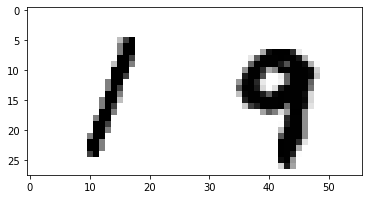

In [6]:
plt.imshow(images[10].cpu().numpy().squeeze(), cmap='gray_r')
print(pr_labels[10], pu_labels[10])

In [7]:
from torch import nn

# # # Build a feed-forward network
san_model = nn.Sequential(nn.Linear(1568, 1024),
                      nn.ReLU(),
                      nn.Linear(1024, 512),
                      nn.ReLU(),
                      nn.Linear(512, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128))

rec_model = nn. Sequential(nn.Linear(128, 256),
                          nn.ReLU(),
                          nn.Linear(256, 512),
                          nn.ReLU(),
                          nn.Linear(512, 1024),
                          nn.ReLU(),
                          nn.Linear(1024, 1568),
                          nn.LeakyReLU())

pr_model = nn.Sequential(nn.Linear(128, 64),
                        nn.ReLU(),
                        nn.Linear(64, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1),
                        nn.Sigmoid())

pu_model = nn.Sequential(nn.Linear(128, 64),
                        nn.ReLU(),
                        nn.Linear(64, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1),
                        nn.Sigmoid())


# san_model = nn.Sequential(
#             nn.Conv2d(1, 16, 3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2),
#             nn.Conv2d(16, 32, 3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2),
#             nn.Conv2d(32, 64, 2)
#         )

# pr_model = nn.Sequential(
#             nn.ConvTranspose2d(64, 32, 3),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.Flatten(),
# #             nn.Linear(3136, 1560),
# #             nn.ReLU(),
# #             nn.Linear(1568, 780),
# #             nn.ReLU(),
# #             nn.Linear(780, 256),
# #             nn.ReLU(),
# #             nn.Linear(336, 128),
# #             nn.ReLU(),
#             nn.Linear(192, 64),
#             nn.ReLU(),
#             nn.Linear(64, 10),
#             nn.ReLU(),
#             nn.Linear(10, 1),
#             nn.Sigmoid()
#             )

# pu_model = nn.Sequential(
#             nn.ConvTranspose2d(64, 32, 3),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.Flatten(),
# #             nn.Linear(3136, 1560),
# #             nn.ReLU(),
# #             nn.Linear(3, 780),
# #             nn.ReLU(),
# #             nn.Linear(780, 256),
# #             nn.ReLU(),
# #             nn.Linear(336, 128),
# #             nn.ReLU(),
#             nn.Linear(192, 64),
#             nn.ReLU(),
#             nn.Linear(64, 10),
#             nn.ReLU(),
#             nn.Linear(10, 1),
#             nn.Sigmoid()
#             )

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
san_model.to(device)
pr_model.to(device)
pu_model.to(device)
rec_model.to(device)

Sequential(
  (0): Linear(in_features=128, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=1568, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
)

In [9]:
pr_optimizer = optim.SGD(pr_model.parameters(), lr=0.001, momentum=0.9)
pu_optimizer = optim.SGD(pu_model.parameters(), lr=0.001, momentum=0.9)
rec_optimizer = optim.SGD(rec_model.parameters(), lr=0.001, momentum=0.9)
san_optimizer = optim.SGD(san_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()
rec_criterion = nn.MSELoss()

train_loss_rec = []
train_loss_pr = []
train_loss_pu = []
train_loss_san = []

time0 = time()
epochs = 300
for e in range(epochs):
    running_loss = 0
    pr_running_loss = 0
    pu_running_loss = 0
    rec_running_loss = 0
    for idx, (images, labels, pr_labels, pu_labels)in enumerate(train_loader):
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.size(0), -1)
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.type(torch.cuda.FloatTensor)
        labels = labels.view(labels.size(0), -1)
        pr_labels = pr_labels.to(device)
        pr_labels = pr_labels.type(torch.cuda.FloatTensor)
        pr_labels = pr_labels.view(pr_labels.size(0), -1)
        pu_labels = pu_labels.to(device)
        pu_labels = pu_labels.type(torch.cuda.FloatTensor)
        pu_labels = pu_labels.view(pu_labels.size(0), -1)    
        
        # Training pass
        if idx%15 != 0:
            pr_optimizer.zero_grad()
            pu_optimizer.zero_grad()
            rec_optimizer.zero_grad()
        
            san_output = san_model(images)
            
            pr_output = pr_model(san_output)
            pr_loss = criterion(pr_output, pr_labels)
            pr_loss.backward(retain_graph=True)
            
            pu_output = pu_model(san_output)
            pu_loss = criterion(pu_output, pu_labels)
            pu_loss.backward(retain_graph=True)
            
            rec_output = rec_model(san_output)
            rec_loss = rec_criterion(rec_output, images)
            rec_loss.backward()
            
            pr_optimizer.step()
            rec_optimizer.step()
            pu_optimizer.step()
            
            pr_running_loss += pr_loss.item()
            pu_running_loss += pu_loss.item()
            rec_running_loss += rec_loss.item()
            
        if idx%15 == 0:
            san_optimizer.zero_grad()
            san_output = san_model(images)
            
            pr_output = pr_model(san_output)
            pr_loss = criterion(pr_output, pr_labels)
            pu_output = pu_model(san_output)
            pu_loss = criterion(pu_output, pu_labels)
            rec_output = rec_model(san_output)
            rec_loss = rec_criterion(rec_output, images)
            
            loss = (50*pu_loss +100*rec_loss) - (30*pr_loss)
#             loss = 30*pu_loss - 4*pr_loss
            loss.backward()
            san_optimizer.step()
        
            running_loss += loss.item()
    else:
        print("Training Epoch {} - San loss: {}, Private loss: {}, Public Loss: {}, Recon Loss: {}".format(e, running_loss/len(train_loader), pr_running_loss/len(train_loader), pu_running_loss/len(train_loader), rec_running_loss/len(train_loader)))
    train_loss_rec.append(rec_running_loss/len(train_loader))
    train_loss_pr.append(pr_running_loss/len(train_loader))
    train_loss_pu.append(pu_running_loss/len(train_loader))
    train_loss_san.append(running_loss/len(train_loader))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Training Epoch 0 - San loss: 1.7440914656500073, Private loss: 0.6622258494119815, Public Loss: 0.6809683645625249, Recon Loss: 0.09910634077151718
Training Epoch 1 - San loss: 1.750287580368159, Private loss: 0.6583473039862445, Public Loss: 0.6707256751139755, Recon Loss: 0.09853764866357265
Training Epoch 2 - San loss: 1.687813534456141, Private loss: 0.6548066213155341, Public Loss: 0.663949744780655, Recon Loss: 0.09787814469669787
Training Epoch 3 - San loss: 1.6916373733364407, Private loss: 0.6531513597806702, Public Loss: 0.658041843520406, Recon Loss: 0.09732428255021724
Training Epoch 4 - San loss: 1.6548245690972603, Private loss: 0.6513071036552225, Public Loss: 0.6541333174156716, Recon Loss: 0.0967123594868671
Training Epoch 5 - San loss: 1.635941854218388, Private loss: 0.6495610948108956, Public Loss: 0.6506533352157954, Recon Loss: 0.0958647148783707
Training Epoch 6 - San loss: 1.6201215363524455, Private loss: 0.648500668804359, Public Loss: 0.6462447958071823, Reco

In [ ]:
from torchvision.utils import save_image

dir = '5/16-pu&pr'

def make_dir():
    image_dir = dir
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
make_dir()

def save_decod_img(img, org_img, epoch):
    img = img.view(img.size(0), 1, 28, 56)
    org_img = org_img.view(org_img.size(0), 1, 28, 56)
    save_image(img, dir+'/image_rec{}.png'.format(epoch))
    save_image(org_img, dir+'/image_org{}.png'.format(epoch))

In [ ]:
path = dir+'/model.pth'

torch.save({
        'san_state_dict': san_model.state_dict(),
        'pr_state_dict' : pr_model.state_dict(),
        'pu_state_dict' : pu_model.state_dict(),
#         'rec_state_dict' : rec_model.state_dict(),
        'san_optimizer_state_dict': san_optimizer.state_dict(),
        'pu_optimizer_state_dict' : pu_optimizer.state_dict(),
        'pr_optimizer_state_dict' : pr_optimizer.state_dict(),
#         'rec_optimizer_state_dict' : rec_optimizer.state_dict(),
        'epoch': epochs,
#         'rec_loss': rec_loss,
        'pr_loss' : pr_loss,
        'pu_loss' : pu_loss,
        'san_loss' : loss, 
#         'rec_losses': train_loss_rec,
#         'pr_losses': train_loss_pr,
#         'pu_losses': train_loss_pu, 
#         'san_losses': train_loss_san
        }, path)

Text(0, 0.5, 'Loss')

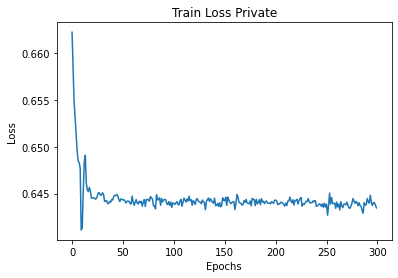

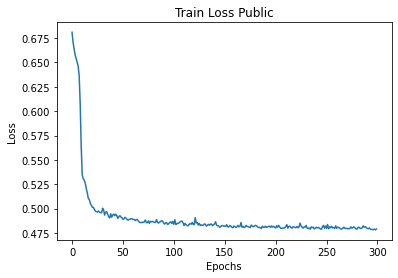

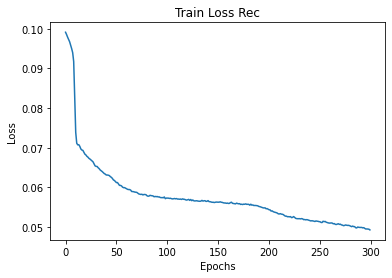

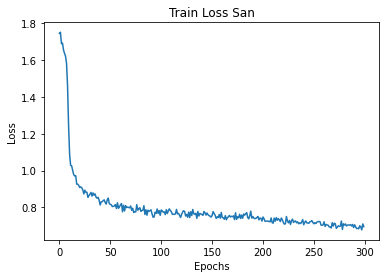

In [10]:
plt.figure()
plt.plot(train_loss_pr)
plt.title('Train Loss Private')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.savefig(dir+'/pr_loss.png')

plt.figure()
plt.plot(train_loss_pu)
plt.title('Train Loss Public')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.savefig(dir+'/pu_loss.png')

plt.figure()
plt.plot(train_loss_rec)
plt.title('Train Loss Rec')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.savefig(dir+'/rec_loss.png')

plt.figure()
plt.plot(train_loss_san)
plt.title('Train Loss San')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.savefig(dir+'/rec_loss.png')

In [11]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.cpu().resize_(1, 28, 56).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(1), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(1))
    ax2.set_yticklabels(np.arange(1))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Public label = [0.]
Private model output value =  0.07926875352859497
Predicted Private label = [0.]


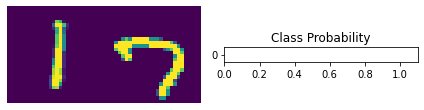

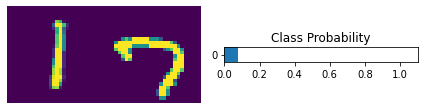

In [20]:
images, labels, pr_labels, pu_labels = next(iter(test_loader))
images = images.view(images.shape[0], -1)
images = images.to(device)
labels = labels.to(device)
labels = labels.type(torch.cuda.FloatTensor)
labels = labels.view(labels.size(0), -1)
pr_labels = pr_labels.to(device)
pr_labels = pr_labels.type(torch.cuda.FloatTensor)
pr_labels = pr_labels.view(pr_labels.size(0), -1)
pu_labels = pu_labels.to(device)
pu_labels = pu_labels.type(torch.cuda.FloatTensor)
pu_labels = pu_labels.view(pu_labels.size(0), -1) 

pu_acc = 0
# Turn off gradients to speed up this part
i = 10
img = images[i].view(1, 1568)

with torch.no_grad():
    san_output = san_model(img)
    pr_output = pr_model(san_output)
    pr_out = pr_output.reshape(-1).cpu().detach().numpy().round()
    pu_output = pu_model(san_output)
    pu_out = pu_output.reshape(-1).cpu().detach().numpy().round() 
    
print("Predicted Public label =", pu_out)
view_classify(img.view(1, 28, 56), pu_output)
print("Private model output value = ", pr_output.item())
print("Predicted Private label =", pr_out)
view_classify(img.view(1, 28, 56), pr_output)

In [21]:
pr_correct_count, pu_correct_count, all_count = 0, 0, 0
for images,labels, pr_labels, pu_labels in test_loader:
    images = images.view(images.shape[0], -1)
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.type(torch.cuda.FloatTensor)
    labels = labels.view(labels.size(0), -1)
    pr_labels = pr_labels.to(device)
    pr_labels = pr_labels.type(torch.cuda.FloatTensor)
    pr_labels = pr_labels.view(pr_labels.size(0), -1)
    pu_labels = pu_labels.to(device)
    pu_labels = pu_labels.type(torch.cuda.FloatTensor)
    pu_labels = pu_labels.view(pu_labels.size(0), -1) 
    
    for i in range(len(labels)):
        img = images[i].view(1, 1568)
        # Turn off gradients to speed up this part
        with torch.no_grad():
            san_output = san_model(img)
            pr_output = pr_model(san_output)
            pu_output = pu_model(san_output)

        # Output of the network are log-probabilities, need to take exponential for probabilities
        pr_pred_label = pr_output.reshape(-1).cpu().detach().numpy().round()
        pr_true_label = pr_labels.cpu().numpy()[i]
        if (pr_true_label == pr_pred_label):
            pr_correct_count += 1
            
        pu_pred_label = pu_output.reshape(-1).cpu().detach().numpy().round()
        pu_true_label = pu_labels.cpu().numpy()[i]
        if (pu_true_label == pu_pred_label):
            pu_correct_count += 1
            
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nPrivate Model Accuracy =", (pr_correct_count/all_count))
print("\nPublic Model Accuracy = ", (pu_correct_count/all_count))

Number Of Images Tested = 4999

Private Model Accuracy = 0.5109021804360873

Public Model Accuracy =  0.9755951190238048


RECONSTRUCTION MODEL

In [220]:
rec_model = nn. Sequential(nn.Linear(128, 256),
                          nn.ReLU(),
                          nn.Linear(256, 512),
                          nn.ReLU(),
                          nn.Linear(512, 1024),
                          nn.ReLU(),
                          nn.Linear(1024, 1568),
                          nn.LeakyReLU())

rec_model.to(device)
rec_criterion = nn.MSELoss()
rec_optimizer = optim.SGD(rec_model.parameters(), lr=0.01, momentum=0.9)



In [256]:
epochs = 50 

# san_model.eval()
# rec_model.train()

for e in range(epochs):
    rec_running_loss = 0
    for idx, (images, labels, pr_labels, pu_labels) in enumerate(train_loader):
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        images = images.to(device)
        
        # Training pass
        rec_optimizer.zero_grad()

        san_output = san_model(images)

        rec_output = rec_model(san_output)
        rec_loss = rec_criterion(rec_output, images)
        rec_loss.backward()
        rec_optimizer.step()

        rec_running_loss += rec_loss.item()
        
            
    else:
        print("Training Epoch {} - Rec loss: {}".format(e, rec_running_loss/len(train_loader)))
        
#     if e % 5 == 0:
#               save_decod_img(rec_output.cpu().data, images.cpu().data, e)
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Training Epoch 0 - Rec loss: 0.057195624508097044
Training Epoch 1 - Rec loss: 0.05701774339217817
Training Epoch 2 - Rec loss: 0.056770883076597965
Training Epoch 3 - Rec loss: 0.056536324088797545
Training Epoch 4 - Rec loss: 0.056490724553804265
Training Epoch 5 - Rec loss: 0.056247511769042295
Training Epoch 6 - Rec loss: 0.05599028579509624
Training Epoch 7 - Rec loss: 0.0561000967536436
Training Epoch 8 - Rec loss: 0.05580484097742516
Training Epoch 9 - Rec loss: 0.05577029188728089
Training Epoch 10 - Rec loss: 0.055603309284390695
Training Epoch 11 - Rec loss: 0.055622692655800554
Training Epoch 12 - Rec loss: 0.0552912936462542
Training Epoch 13 - Rec loss: 0.05528415300314079
Training Epoch 14 - Rec loss: 0.05504463810730926
Training Epoch 15 - Rec loss: 0.05499777013002454
Training Epoch 16 - Rec loss: 0.05487091483934151
Training Epoch 17 - Rec loss: 0.05481001448905681
Training Epoch 18 - Rec loss: 0.05463988080030055
Training Epoch 19 - Rec loss: 0.05447860768117258
Train

In [22]:
def view_image(img):
    ''' Function for viewing an image and it's predicted classes.
    '''
    fig, (ax1) = plt.subplots(figsize=(6,9), ncols=1)
    ax1.imshow(img.cpu().resize_(1, 28, 56).numpy().squeeze())
    ax1.axis('off')
    plt.tight_layout()

In [27]:
images, labels, pr_labels, pu_labels = next(iter(test_loader))
images = images.view(images.shape[0], -1)
images = images.to(device)

i = 10
img = images[i].view(1, 1568)

with torch.no_grad():
    for i in range(10):
        img = images[i].view(1, 1568)
        san_output = san_model(img)
        rec_output = rec_model(san_output)

        view_image(rec_output.view(1, 28, 56))
        view_image(img.view(1, 28, 56))

RuntimeError: CUDA error: device-side assert triggered

NEW PRIVATE MODEL